In [1]:
import pandas as pd
import numpy as np

import re
import os
import string

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
tweet = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/refs/heads/master/train.csv")

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Data Analysis

## Target Class Distribution

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80


Text(0.5, 1.0, 'Real or not real disaster tweets')

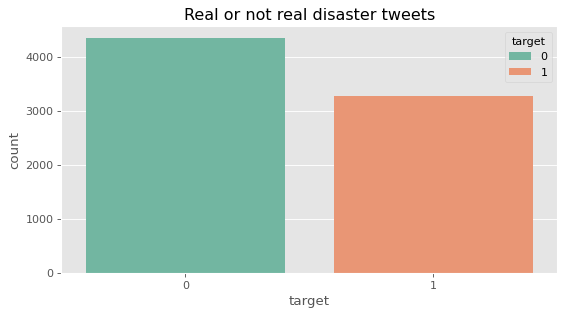

In [7]:
sns.countplot(tweet, x="target", hue="target", palette = "Set2")
plt.title('Real or not real disaster tweets')

In [8]:
tweet['target'].value_counts()

,count
target,
0,4342
1,3271


<Axes: ylabel='count'>

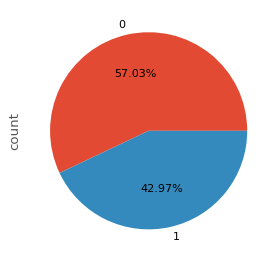

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

# Number of Characters in tweet distribution

In [10]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie_old.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie_old.git to /tmp/pip-req-build-uvcx4gx7
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie_old.git /tmp/pip-req-build-uvcx4gx7
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie_old.git to commit e5b1f0710cb1ea5ebbc73d30abe8d45a07cbb399
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess_kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7617 sha256=228a42593b1b5638503133b9e95ed0488f52f6b9f55a12d73a998c36d80a6e8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwx62gvs/wheels/c0/00/89/c571736e96e582dfd8410b0177274991bd821016a96af3f958
Successfully built preprocess_kgptalkie


In [11]:
import preprocess_kgptalkie as kgp

In [12]:
kgp.get_basic_features(tweet)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


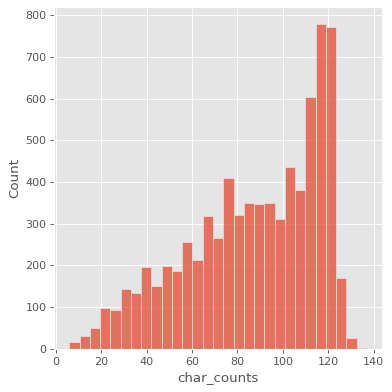

In [13]:
sns.displot(tweet['char_counts'])

<Axes: xlabel='char_counts', ylabel='Density'>

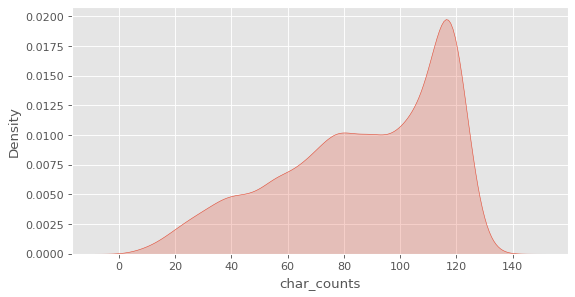

In [14]:
sns.kdeplot(tweet['char_counts'], fill=True)

<Axes: xlabel='char_counts', ylabel='Density'>

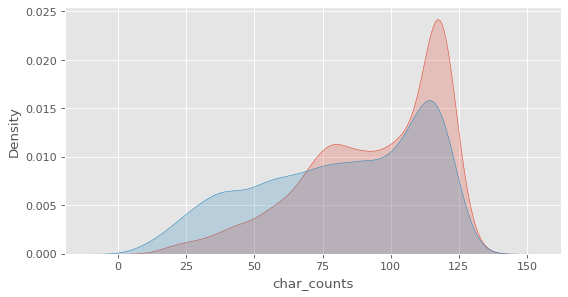

In [15]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], fill=True)
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], fill=True)

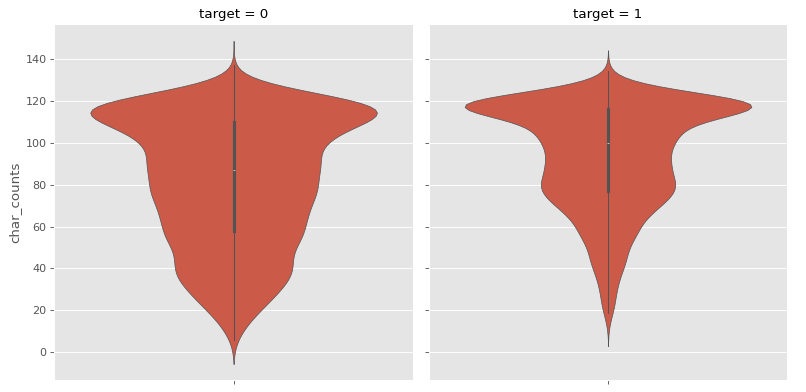

In [16]:
sns.catplot(y='char_counts',data=tweet, kind='violin', col='target')

<Axes: xlabel='word_counts', ylabel='Density'>

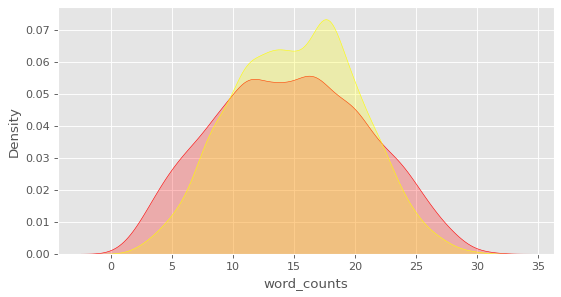

In [17]:
sns.kdeplot(tweet.loc[tweet['target'] == 0, 'word_counts'], fill=True, color='red')
sns.kdeplot(tweet.loc[tweet['target'] == 1, 'word_counts'], fill=True, color='yellow')

<Axes: xlabel='avg_wordlength', ylabel='Density'>

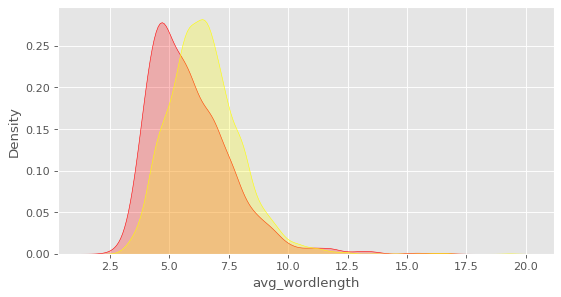

In [18]:
sns.kdeplot(tweet.loc[tweet['target'] == 0, 'avg_wordlength'], fill=True, color='red')
sns.kdeplot(tweet.loc[tweet['target'] == 1, 'avg_wordlength'], fill=True, color='yellow')

<Axes: xlabel='stopwords_counts', ylabel='Density'>

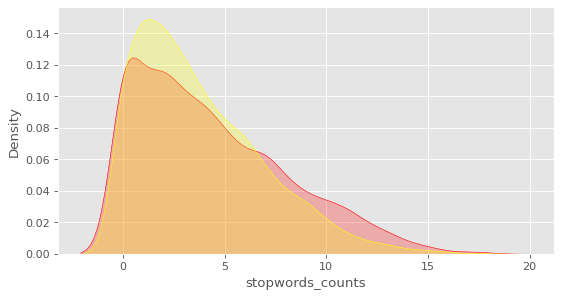

In [19]:
sns.kdeplot(tweet.loc[tweet['target'] == 0, 'stopwords_counts'], fill=True, color='red')
sns.kdeplot(tweet.loc[tweet['target'] == 1, 'stopwords_counts'], fill=True, color='yellow')

In [20]:
freqs = kgp.get_word_freqs(tweet,'text')

In [21]:
top20 = freqs[100:120]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'back'),
  Text(1, 0, 'see'),
  Text(2, 0, '@YouTube'),
  Text(3, 0, '3'),
  Text(4, 0, 'go'),
  Text(5, 0, 'THE'),
  Text(6, 0, 'RT'),
  Text(7, 0, 'time'),
  Text(8, 0, 'Is'),
  Text(9, 0, 'disaster'),
  Text(10, 0, 'think'),
  Text(11, 0, 'buildings'),
  Text(12, 0, 'Full'),
  Text(13, 0, 'bomb'),
  Text(14, 0, 'suicide'),
  Text(15, 0, 'body'),
  Text(16, 0, 'want'),
  Text(17, 0, 'Emergency'),
  Text(18, 0, 'How'),
  Text(19, 0, 'down')])

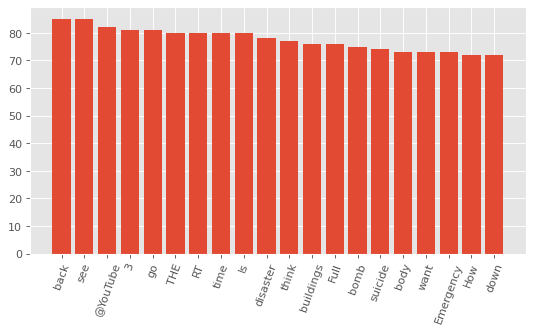

In [22]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)

In [23]:
bigram = kgp.get_ngram(tweet, col='text', ngram_range=2)
bigram[:20]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476)]

In [24]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [25]:
tweet['text'] = tweet['text'].apply(lambda x:get_clean(x))

/usr/local/lib/python3.11/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [26]:
tweet.head()['text']

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,130 people receive wildfires evacuation orders...
4,just got sent this photo from ruby alaska as s...


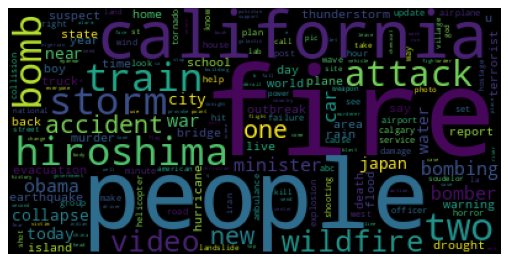

In [27]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
wordcloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

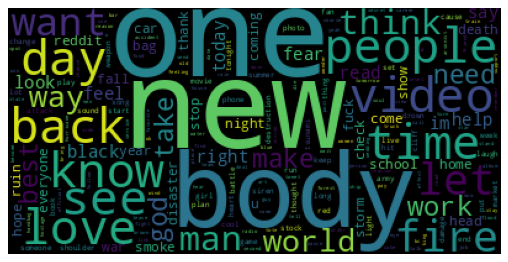

In [28]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
wordcloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Classification with TFIDF and SVM

In [29]:
text, y = tweet['text'], tweet['target']

In [30]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [32]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [33]:
from sklearn.svm import LinearSVC

In [34]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



# Classification with word2vec and SVM

In [35]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [36]:
import spacy
import en_core_web_lg

In [37]:
nlp = en_core_web_lg.load()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [38]:
x = 'cat dog'
doc = nlp(x)
doc.vector.shape

(300,)

In [39]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [40]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [41]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [42]:
X.shape

(7613, 1)

In [43]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1,300)

In [44]:
X.shape

(7613, 300)

In [45]:
y = tweet['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [47]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       869
           1       0.80      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 1.74 s, sys: 39.1 ms, total: 1.78 s
Wall time: 1.77 s


# Word Embedding classification with Deep learning

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPool1D

In [49]:
token = Tokenizer()
token.fit_on_texts(text)

In [50]:
vocab_size = len(token.word_index)+1
vocab_size

22582

In [51]:
encoded_text = token.texts_to_sequences(text)
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 371, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [53]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
X.shape

(7613, 40)